### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

_The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value')._

# 1. Getting the Data

In [122]:
import pandas as pd

In [123]:
!wget -O data.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-11-11 12:47:09--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘data.csv’

100%[======================================>] 1,423,529   --.-K/s   in 0.007s  

2023-11-11 12:47:09 (207 MB/s) - ‘data.csv’ saved [1423529/1423529]



In [124]:
df = pd.read_csv('data.csv')

In [125]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 2. Preparing the dataset

In [126]:
# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df.loc[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [127]:
# Dropping the index, so that we have a reference.
df = df.reset_index(drop=True)

In [128]:
# Filling missing values with zeros. Only the total_bedrooms column has missing values.
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [129]:
# Applying the log transform to median_house_value.
import numpy as np

In [130]:
df.median_house_value = np.log10(df.median_house_value)

In [244]:
df.ocean_proximity.unique()

array(['1H OCEAN', 'INLAND'], dtype=object)

In [234]:
df.ocean_proximity = df.loc[df.ocean_proximity == '<1H OCEAN'] = '1H OCEAN'

In [245]:
# Do train/validation/test split with 60%/20%/20% distribution.
# First split is 20% for testing. Second split is 25% for validation.
from sklearn.model_selection import train_test_split

In [246]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [247]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [248]:
# Reseting the indexes
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [249]:
y_full_train = df_full_train.median_house_value.values
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [250]:
del df_full_train['median_house_value']
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [251]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
from sklearn.feature_extraction import DictVectorizer

In [252]:
full_train_dicts = df_full_train.to_dict(orient='records')
train_dicts = df_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [253]:
dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(full_train_dicts)
X_train = dv.fit_transform(train_dicts)
X_test = dv.fit_transform(test_dicts)
X_val = dv.fit_transform(val_dicts)

## Question 1
Let's train a decision tree regressor to predict the median_house_value variable.

In [140]:
from sklearn.tree import DecisionTreeRegressor

In [141]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [142]:
# Q. Which feature is used for splitting the data? R: feature_6 = population
from sklearn.tree import export_text
print(export_text(dt))

|--- feature_6 <= 0.50
|   |--- value: [5.34]
|--- feature_6 >  0.50
|   |--- value: [5.04]



# Question 2
Train a random forest model with these parameters

In [143]:
from sklearn.ensemble import RandomForestRegressor

In [153]:
regr = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [154]:
from sklearn.metrics import mean_squared_error

In [155]:
# Q. What's the RMSE of this model on validation? R: 0.1059
y_pred = regr.predict(X_val)
rms = mean_squared_error(y_val, y_pred, squared=False)
rms

0.10591793363560827

## Question 3
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

In [158]:
import matplotlib.pyplot as plt

In [ ]:
rms = []
x = list(range(10, 210, 10))
for x in range(10, 210, 10):
    regr = RandomForestRegressor(n_estimators=x, n_jobs=-1, random_state=1)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_val)
    rms.append(mean_squared_error(y_val, y_pred, squared=False))
    print(x)

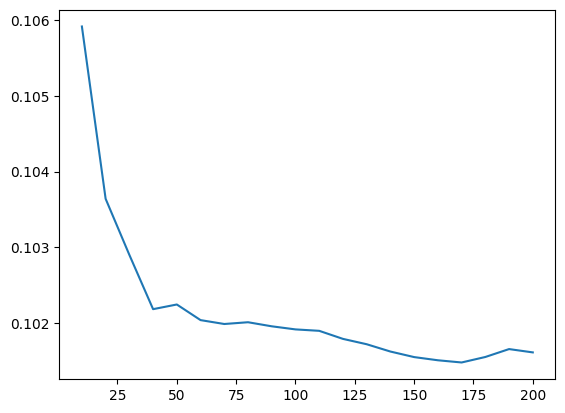

In [190]:
plt.plot(x,rms)

In [194]:
# Q. After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.
# R: ~40
np.round(rms, 3)

array([0.106, 0.104, 0.103, 0.102, 0.102, 0.102, 0.102, 0.102, 0.102,
       0.102, 0.102, 0.102, 0.102, 0.102, 0.102, 0.102, 0.101, 0.102,
       0.102, 0.102])

## Question 4

In [196]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 210, 10):
        regr = RandomForestRegressor(n_estimators=n, max_depth=d, n_jobs=-1, random_state=1)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_val)
        rms = mean_squared_error(y_val, y_pred, squared=False)
        scores.append((n, d, rms))
        print(d, n)

10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
10 100
10 110
10 120
10 130
10 140
10 150
10 160
10 170
10 180
10 190
10 200
15 10
15 20
15 30
15 40
15 50
15 60
15 70
15 80
15 90
15 100
15 110
15 120
15 130
15 140
15 150
15 160
15 170
15 180
15 190
15 200
20 10
20 20
20 30
20 40
20 50
20 60
20 70
20 80
20 90
20 100
20 110
20 120
20 130
20 140
20 150
20 160
20 170
20 180
20 190
20 200
25 10
25 20
25 30
25 40
25 50
25 60
25 70
25 80
25 90
25 100
25 110
25 120
25 130
25 140
25 150
25 160
25 170
25 180
25 190
25 200


In [197]:
df_scores = pd.DataFrame(scores, columns=['n', 'd', 'rms'])

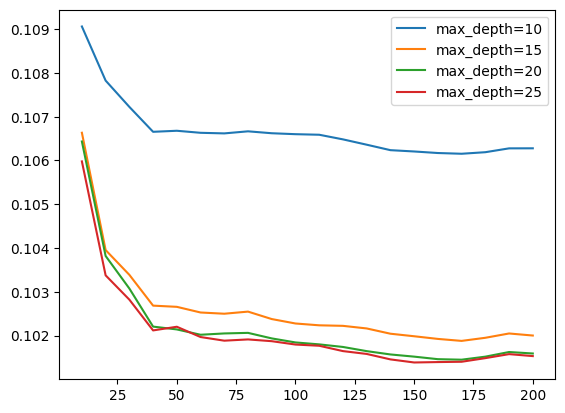

In [207]:
# Q: What's the best max_depth, using the mean RMSE? A: max_depth = 25
for s in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.d == s]
    plt.plot(df_subset.n,
             df_subset.rms, 
             label='max_depth=%d' % s)
    
plt.legend()

In [208]:
regr = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [215]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

<BarContainer object of 10 artists>

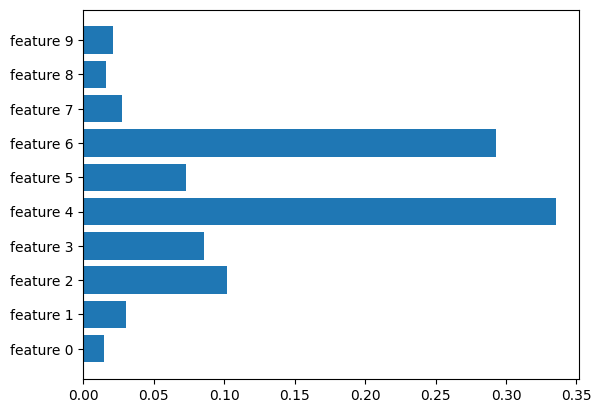

In [216]:
# Q: What's the most important feature (among these 4)? A: total_bedrooms -> feature 4
plt.barh(feature_names, regr.feature_importances_)

## Question 6

In [217]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/ee/2c/03d466d00818c8e0ffcf778946ca4a5e05694a11b85bc51f1bc5c18ca54e/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [254]:
import xgboost as xgb

In [255]:
features = dv.get_feature_names_out()
x = features.tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=x)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=x)

In [256]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [258]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params,
                  dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200)

In [269]:
output.stdout

'[0]\ttrain-rmse:0.19261\tval-rmse:0.19218\n[5]\ttrain-rmse:0.11004\tval-rmse:0.11927\n[10]\ttrain-rmse:0.09313\tval-rmse:0.10935\n[15]\ttrain-rmse:0.08624\tval-rmse:0.10650\n[20]\ttrain-rmse:0.08045\tval-rmse:0.10414\n[25]\ttrain-rmse:0.07712\tval-rmse:0.10349\n[30]\ttrain-rmse:0.07334\tval-rmse:0.10237\n[35]\ttrain-rmse:0.06998\tval-rmse:0.10169\n[40]\ttrain-rmse:0.06750\tval-rmse:0.10127\n[45]\ttrain-rmse:0.06489\tval-rmse:0.10071\n[50]\ttrain-rmse:0.06313\tval-rmse:0.10086\n[55]\ttrain-rmse:0.06145\tval-rmse:0.10074\n[60]\ttrain-rmse:0.05958\tval-rmse:0.10049\n[65]\ttrain-rmse:0.05759\tval-rmse:0.10057\n[70]\ttrain-rmse:0.05621\tval-rmse:0.10018\n[75]\ttrain-rmse:0.05453\tval-rmse:0.10006\n[80]\ttrain-rmse:0.05295\tval-rmse:0.09939\n[85]\ttrain-rmse:0.05148\tval-rmse:0.09940\n[90]\ttrain-rmse:0.04996\tval-rmse:0.09936\n[95]\ttrain-rmse:0.04893\tval-rmse:0.09930\n[100]\ttrain-rmse:0.04776\tval-rmse:0.09935\n[105]\ttrain-rmse:0.04688\tval-rmse:0.09931\n[110]\ttrain-rmse:0.04567\tval-

In [270]:
s = output.stdout.split('\n')
line = s[0]
num_iter, train_rmse, val_rmse = line.split('\t')
num_iter = int(num_iter.strip('[]'))

In [271]:
train_rmse = float(train_rmse.split(':')[1])

In [272]:
val_rmse = float(val_rmse.split(':')[1])

In [273]:
def parse_xgb_output(output):
    results = []
    tree = []
    rmse_train = []
    rmse_val = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
    
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        tree.append(it)
        rmse_train.append(train)
        rmse_val.append(val)
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [278]:
df_score_1 = parse_xgb_output(output)

In [279]:
df_score_1

,num_iter,train_rmse,val_rmse
0,0,0.19261,0.19218
1,5,0.11004,0.11927
2,10,0.09313,0.10935
3,15,0.08624,0.10650
4,20,0.08045,0.10414
5,25,0.07712,0.10349
6,30,0.07334,0.10237
7,35,0.06998,0.10169
8,40,0.06750,0.10127
9,45,0.06489,0.10071


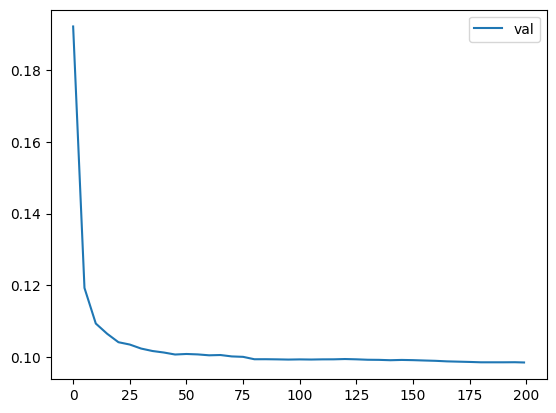

In [280]:
plt.plot(df_score_1.num_iter, df_score_1.val_rmse, label='val')
plt.legend()

In [282]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params,
                  dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200)

In [283]:
df_score_2 = parse_xgb_output(output)

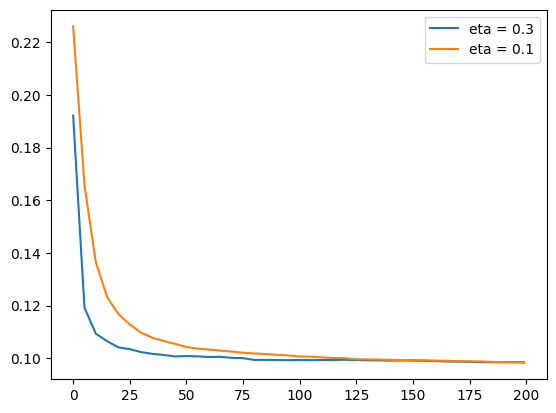

In [285]:
# Q: Which eta leads to the best RMSE score on the validation dataset? A: eta = 0.3
plt.plot(df_score_1.num_iter, df_score_1.val_rmse, label = "eta = 0.3") 
plt.plot(df_score_2.num_iter, df_score_2.val_rmse, label = "eta = 0.1") 
plt.legend() 
plt.show()